# Overview

The goal of this project is to take in simple voltage vs. current data for my gold nanowire devices and to investigate how the rate of breaking depends on the dissipated power in the junction. Ultimately I would like a python script that can loop over all the data files in a directory and perform this analysis.

I always start a lab notebook by loading my file of useful code functions. It is reloaded with autoreload magic where the "1" means that it will only reload imported modules that are specifically designated for reload by the %aimport magic.

In [1]:
# this imports my snp.py useful snippets module, and autoreloads it before running any code
%load_ext autoreload
%autoreload 1
%aimport snips
snp = snips

In [2]:
# standard package imports
import math
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
# import seaborn as sns

# import my modules
%aimport prepdata
%aimport smoothdata
%aimport splderiv

# import and modify default aesthetics of matplotlib, also use a magic to have it plot interactively inline in the notebook.
import matplotlib
snp.prettyplot(matplotlib)

%matplotlib notebook  # set up interactive backend for matplotlib pyplot submodule. This is now recommended over ipython --pylab

Here are some commands that should be run upon opening the notebook for a new session:

In [3]:
cwd = os.getcwd()
datadir = cwd + "\OriginalData"
datafile = datadir+"\EMC1_1112.txt"

df = prepdata.prepdata(datafile)

# lowess = sm.nonparametric.lowess

In [4]:
rlab = "Resistance ($\Omega$)"
logrlab = "Log(R) ($\Omega$)"
ilab = "Current (A)"
vlab = "Voltage (V)"
tmlab = "Time (Arb. Units)"

<h1 style="background-color:yellow">160531</h1>

I'm going to work with with a test file where I already know what the final result should be based on my Matlab script. I'm going to keep this original file in a subdirectory of this project folder called "Original Data"

Since this notebook dictates the CWD and it lives in that project folder (Box Sync\Projects\python-em-breaking-rate) all my paths should be relative to that. My data is in the folder "OriginalData" in this project directory

My data is the text file. I happen to know that the data has two header lines where the second one contains the actual variable (column names). But I also might want some info from the first header line (which gives info about the experiment and whatnote). At any rate, here is a good snippet to read in the first few lines and show them. 

In [10]:
import os
cwd = os.getcwd()
datadir = cwd + "\OriginalData"
print(os.listdir(datadir))

['EMC1_1112.txt', 'EMC1_1112_dRdt_vs_P.png', 'EMC3_1501.txt']


In [11]:
datafile = datadir+"\EMC1_1112.txt"
snp.viewheads(datafile)

DELAY (SEC) -107374176.000 ; RAMP (V) 0.0005 ; MAX VOLT (V) 2.00 ; RAMP RESISTANCE TOLERANCE (low R) (float %) -107374176.000 ; RAMP RESISTANCE TOLERANCE (low-med R) (float %) -107374176.000 ; RAMP RESISTANCE TOLERANCE (med-high R) (float %) -107374176.000 ; RAMP RESISTANCE TOLERANCE (high R) (float %) -107374176.000 ; TARGET RESISTANCE (Ohms) 10000.000000000 ; TARGET RESISTANCE TOLERANCE (float %) 0.001 ; RAMP DOWN (V) -107374176.000 ; NUM CONSEC HITS (low R) -858993460 ; NUM CONSEC HITS (low-med R) -858993460 ;  NUM CONSEC HITS (med-high R) -858993460 ; NUM CONSEC HITS (high R) -858993460 ; NUM CONSEC NDR (low R) -858993460 ; NUM CONSEC HITS (low-med R) -858993460 ; NUM CONSEC HITS (med-high R) -858993460 ; NUM CONSEC NDR (high R) -858993460 ; LOW/LOW-MED SWITCH RESISTANCE (ohms) -107374176.000000000 ; LOW-MED/MED-HIGH SWITCH RESISTANCE (ohms) -107374176.000000000 ; MED-HIGH/HIGH SWITCH RESISTANCE (ohms) -107374176.000000000 ;  INTEGRATION TIME (PLC) 1 ; RAMPDOWN DWELL (msec/mV) -858

In [12]:
expdata = snp.captureheads(datafile, 1)
print(expdata)

['DELAY (SEC) -107374176.000 ; RAMP (V) 0.0005 ; MAX VOLT (V) 2.00 ; RAMP RESISTANCE TOLERANCE (low R) (float %) -107374176.000 ; RAMP RESISTANCE TOLERANCE (low-med R) (float %) -107374176.000 ; RAMP RESISTANCE TOLERANCE (med-high R) (float %) -107374176.000 ; RAMP RESISTANCE TOLERANCE (high R) (float %) -107374176.000 ; TARGET RESISTANCE (Ohms) 10000.000000000 ; TARGET RESISTANCE TOLERANCE (float %) 0.001 ; RAMP DOWN (V) -107374176.000 ; NUM CONSEC HITS (low R) -858993460 ; NUM CONSEC HITS (low-med R) -858993460 ;  NUM CONSEC HITS (med-high R) -858993460 ; NUM CONSEC HITS (high R) -858993460 ; NUM CONSEC NDR (low R) -858993460 ; NUM CONSEC HITS (low-med R) -858993460 ; NUM CONSEC HITS (med-high R) -858993460 ; NUM CONSEC NDR (high R) -858993460 ; LOW/LOW-MED SWITCH RESISTANCE (ohms) -107374176.000000000 ; LOW-MED/MED-HIGH SWITCH RESISTANCE (ohms) -107374176.000000000 ; MED-HIGH/HIGH SWITCH RESISTANCE (ohms) -107374176.000000000 ;  INTEGRATION TIME (PLC) 1 ; RAMPDOWN DWELL (msec/mV) -8

## Reading in the data, renaming columns
Now I can use pandas to get the useful stuff into a dataframe

In [13]:
df = pd.read_csv(datafile, header=1, sep=",")  # header is the number of lines to skip, and after that first line is column names

In [14]:
df.head()

,voltage,current,resistance
0,0.55,0.002762,199.115356
1,0.55,0.002762,199.117081
2,0.55,0.002762,199.124649
3,0.55,0.002762,199.123215
4,0.55,0.002762,199.124588


In [15]:
df.describe()

,voltage,current,resistance
count,2133.000000,2133.000000,2133.000000
mean,0.584527,0.002428,438.822737
std,0.013464,0.000974,498.071078
min,0.550000,0.000324,199.115356
25%,0.576500,0.002788,199.763428
50%,0.593500,0.002893,200.705688
75%,0.593500,0.002945,204.453094
max,0.593500,0.002963,1831.321411


Obviously a plot of $I$ (current) and $R$ resistance versus $V$ voltage is going to be a lot more useful to us. To start with though I'll rename the columns to something faster to type.

In [16]:
print(list(df.columns)) # sneaky!! there are spaces in some of the names!
df.rename(columns={" voltage": "v", "current": "i", "resistance ": "r"}, inplace = True)  # inplace modifies this DF

[' voltage', 'current', 'resistance ']


In this case there isn't really a 'timestamp' for each data point it is just assumed that they occur at regular intervals because the instrument is integrating for a fixed amount of time, so we will probably just use the row indices as a stand-in for time (then we can plot time with `df.index.tolist()`) as the time axis for plotting and we will say it is in "arbitrary units". 

I'm going to want to plot current, resistance, power, rate and time reasonably often so let me make some objects in my snp module that I can just pass in as axes. Also I'll rename the matplotlib methods for easier access:

In [27]:
rlab = "Resistance ($\Omega$)"
ilab = "Current (A)"
vlab = "Voltage (V)"
tmlab = "Time (Arb. Units)"

## Preliminary Visualization of Variables

<IPython.core.display.Javascript object>


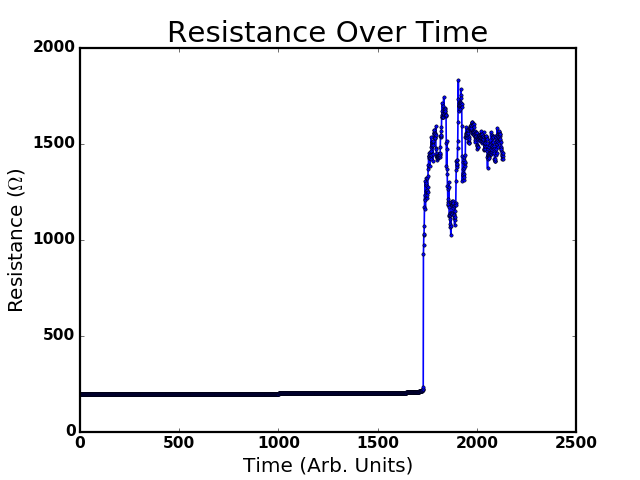

In [13]:
rplot = snp.plotz(plt, df.index.tolist(), df.r, tmlab, rlab, "Resistance Over Time")z

<IPython.core.display.Javascript object>


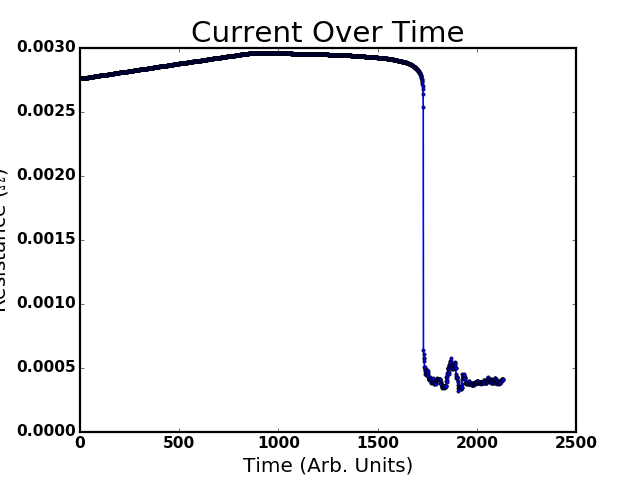

In [13]:
iplot = snp.plotz(plt, df.index.tolist(), df.i, tmlab, rlab, "Current Over Time")

<IPython.core.display.Javascript object>


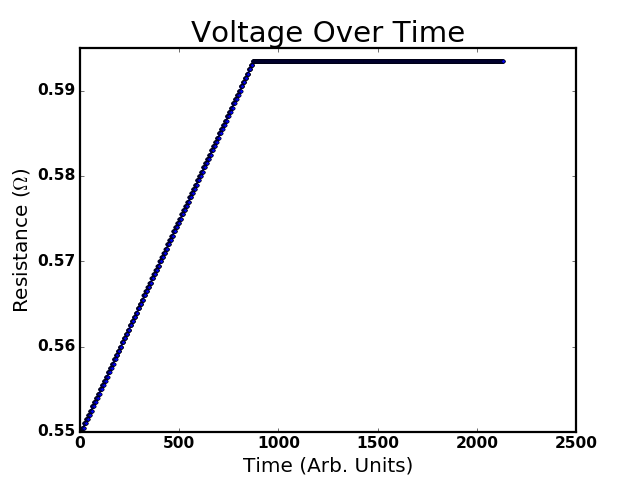

In [14]:
vplot = snp.plotz(plt, df.index.tolist(), df.v, tmlab, rlab, "Voltage Over Time")

## Removing Voltage Ramp-Up Prior to EM Beginning
I can see that the what happened was the voltage ramped up until it detected the onset of EM, then it just held it's fixed value for the rest of the scan. I want to know what data point that occurred at, so I will get the row indexe of the data point with the maximum voltage - there will be lots of these data points but `max()` will return the first one! It should be around 900.

In [17]:
voltagedwell = df.v.idxmax()
print(voltagedwell)

870


OK now I'm going to just drop the entire data frame up to this point:

In [18]:
dfcut = df.loc[voltagedwell:]
dfcut.head()

,v,i,r
870,0.5935,0.002962,200.338821
871,0.5935,0.002962,200.342957
872,0.5935,0.002963,200.331863
873,0.5935,0.002963,200.332336
874,0.5935,0.002963,200.332611


<IPython.core.display.Javascript object>


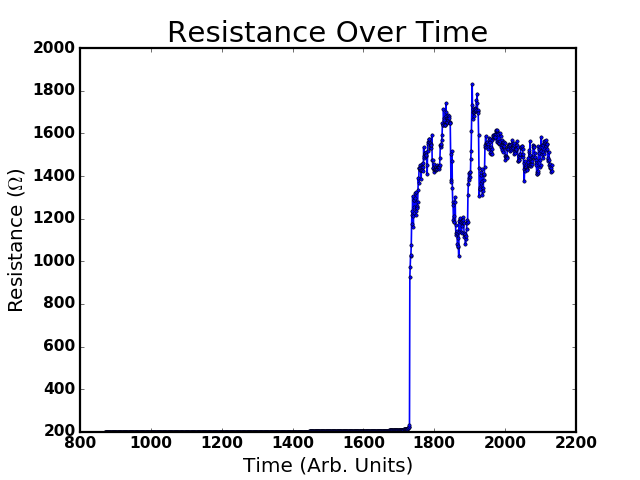

In [131]:
snp.plotz(plt, dfcut.index.tolist(), dfcut.r, tmlab, rlab, "Resistance Over Time")

## Removing Rseries to get Rj (and Pj)
Ultimately what I'm interested in is the breaking rate $\frac{dR_j}{dt}$ as a function of the junction power $P_j$, where $R$ is a resistance, $P$ a power, and subscript $j$ indicates quantity is for the electromigration junction.

First of all $R_j$ = $R$ - $R_L$ where $R$ is the actual measured resistance in the file and $R_L$. Then we use the joule heating relation $P_j=I^2R_j$ to get the junction power. First we'll estimate $R_L$ from the portion of the data that we discarded earlier - the voltage ramp up prior to EM occurring. 

This is a bit tricky for two reasons - (1) because we do expect some joule-heating induced increases in the series resistance as the voltage increases and (2) we do expect that some EM was occurring and changing the resistance before the program actually caught on and began dwelling the voltage. For both these reasons it may be appropriate to discard the highest voltage regime. But let's take a look first. Recall that voltage dwell is the row index at which the voltage dwelling begins, so we want everything before that point.

In [19]:
dflowv = df.loc[:voltagedwell]
dflowv.head()

,v,i,r
0,0.55,0.002762,199.115356
1,0.55,0.002762,199.117081
2,0.55,0.002762,199.124649
3,0.55,0.002762,199.123215
4,0.55,0.002762,199.124588


In [165]:
snp.plotz(plt, dflowv.index.tolist(), dflowv.r, tmlab, rlab, "Resistance Over Time")

This is somewhat messy and non-linear. It also shows that the total resistance only changes by about 1 $\Omega$. We should be fine just setting the series resistance to the mean of this data.

In [21]:
Rseries = dflowv.r.mean()
print(Rseries)

199.65431081285897


Now that I have an estimate of the series resistance I want to make two new columns in the DF - one will be $R_j = R - R_L$ and the other will be $P_j = I^2*R_j$.

In [27]:
dfcut["rj"] = dfcut.r-Rseries
# dfcut["pj"] = dfcut.rj*dfcut.i**2
# dfcut.head()

C:\Users\Sonya\Anaconda3\lib\site-packages\pandas\core\indexing.py:545: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value


## Making a Time Column
Lets also make an explicit column that is the "time" in arbitrary units. It can be the index minus the first value of the index so that EM is considered to start at t = 0.

In [164]:
# Make the index a column for easier referencing, since it is standing in for time here
dfcut["time"] = dfcut.index.tolist()
dfcut.time = dfcut.time - dfcut.time.min()  # the minimum of this new time column will be the value of the smallest row index
dfcut.head()

C:\Users\Sonya\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\Sonya\Anaconda3\lib\site-packages\pandas\core\generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,v,i,r,rj,pj,time
870,0.5935,0.002962,200.338821,0.685297,0.000006,0
871,0.5935,0.002962,200.342957,0.689433,0.000006,1
872,0.5935,0.002963,200.331863,0.678339,0.000006,2
873,0.5935,0.002963,200.332336,0.678812,0.000006,3
874,0.5935,0.002963,200.332611,0.679087,0.000006,4


<IPython.core.display.Javascript object>


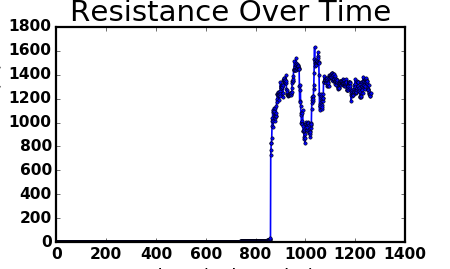

In [231]:
snp.plotz(plt, dfcut.time, dfcut.rj, tmlab, rlab, "Resistance Over Time")

## Switching to Log(Rj) 
It's really messy at the other end too - maybe I could try some sort of noise estimation function that could tell me how noisy the data is at different parts of the curve and then I could cut the DF again based on that? What would be a measure of this? Return to this later I guess. Since the resistance is spanning an order of magnitude, let's trying looking at log(R).

In [177]:
dfcut["logrj"] = dfcut.rj.apply(math.log10)

C:\Users\Sonya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


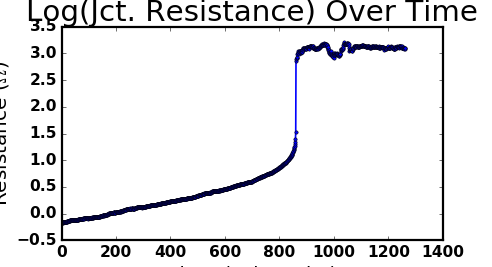

In [232]:
snp.plotz(plt, dfcut.time, dfcut.logrj, tmlab, rlab, "Log(Jct. Resistance) Over Time")
# plt.semilogy(dfcut.time, dfcut.logrj)

This is a clearer way to visualize the data. We'll work with log(Rj) from now on. 

## Smoothing of log(Rj)
Now I'm going to need a numerical derivative of the rj column with respect to "time" AKA the row index. That means I'm going to need to do some serious smoothing of rj, and then probably also of the derivative. The difficulty lies in the nature of the traces - they are smooth and slowly varying up to some point where the rate of change of resistance explodes, and then once the junction has broken to a few-atom contact the rate of change drops to almost nothing again, but this time with huge fluctuations about the mean. I would like to label some of these regions as follows:
- The gradual slow run-up to the measurable resistance change is the **"ramp"**
- The region of high curvature between the "ramp" and the extremely vertical climb is called the **"knee"**
- The region of extremely rapid change in resistance is called the **"climb"**
- The region where the rate of change drops off again and the data become very noisy is called the **"plateau"**

Let's try some naive application of smoothing and see what problems we run into. 

<IPython.core.display.Javascript object>


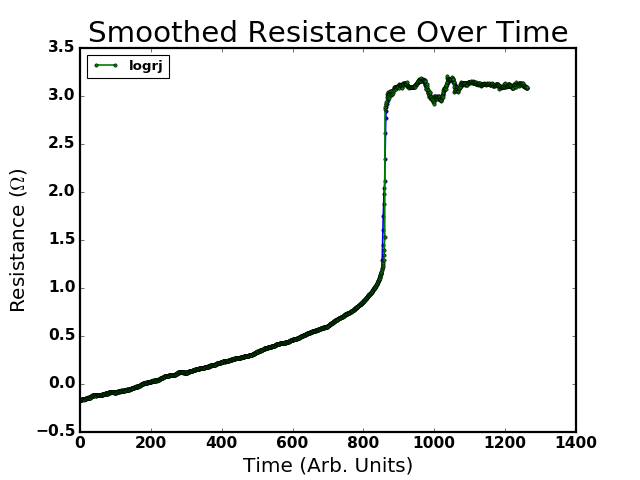

In [234]:
# ...lowess(ydata, xdata, (frac of total points to use as smoothing span),...
# (num of iterations to smooth), (return data sorted by x-vals), (ignore points already within delta of neighbors)
# lowess returns a numpy array, so we need to pull out the smoothed y-values.
lowess = sm.nonparametric.lowess  # rename module method for easier access
smoothed_logrj = lowess(dfcut.logrj, dfcut.time, 0.015, 4, is_sorted=False, delta = 0.1)[:,1] 

smooth_logrj = snp.plotz(plt, dfcut.time, smoothed_logrj, tmlab, rlab, "Smoothed Resistance Over Time")
normal_logrj = snp.plotz(plt, dfcut.time, dfcut.logrj, tmlab, rlab, "Smoothed Resistance Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=2, loc = "upper left")
# plt.legend.loc()

## Residuals as Indicator of "Climb" Region
When we zoom in on the above plot in the various regions we can see clearly that the amount of smoothing necessary to handle the "plateau" noisiness is going to completely wash the "knee" region into the "climb" region. I think what we need to do is categorize each data point into one of the four regions and then apply different smoothing to them, and finally piece them back together. Is there a way to recognize the different regions programmatically? Yes, probably. For starters, lets look at the residuals of the smoothed curve:

In [236]:
dfcut["residuals"]=dfcut.logrj-smoothed_logrj

C:\Users\Sonya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [237]:
dfcut.head()

,v,i,r,rj,pj,time,logrj,sm_residuals,residuals
870,0.5935,0.002962,200.338821,0.685297,0.000006,0,-0.164121,0.003298,0.001799
871,0.5935,0.002962,200.342957,0.689433,0.000006,1,-0.161508,0.004942,0.003618
872,0.5935,0.002963,200.331863,0.678339,0.000006,2,-0.168553,-0.003076,-0.004222
873,0.5935,0.002963,200.332336,0.678812,0.000006,3,-0.168251,-0.003748,-0.004702
874,0.5935,0.002963,200.332611,0.679087,0.000006,4,-0.168075,-0.004549,-0.005287


<IPython.core.display.Javascript object>


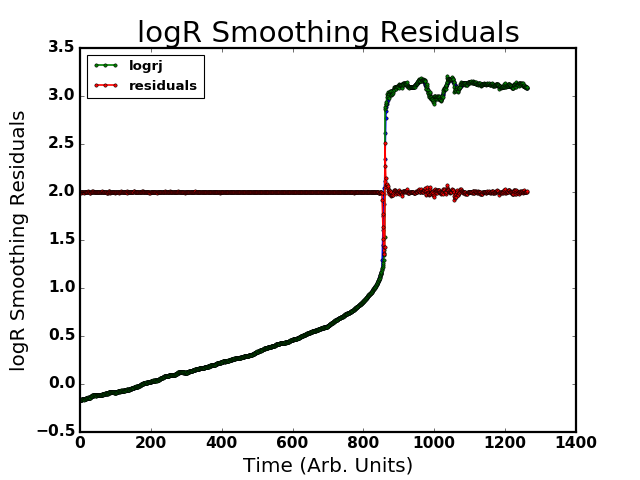

In [244]:
smooth_logrj = snp.plotz(plt, dfcut.time, smoothed_logrj, tmlab, rlab, "Smoothed Resistance Over Time")
normal_logrj = snp.plotz(plt, dfcut.time, dfcut.logrj, tmlab, rlab, "Smoothed Resistance Over Time")

shifted_residuals = dfcut.residuals + 2
snp.plotz(plt, dfcut.time, shifted_residuals, tmlab, "logR Smoothing Residuals", "logR Smoothing Residuals")
plt.legend(numpoints=3, loc="upper left")

It seems like applying a naive smoothing of something like the above parameters may be able to show through it's residuals where are the regions that more care is needed.

<IPython.core.display.Javascript object>


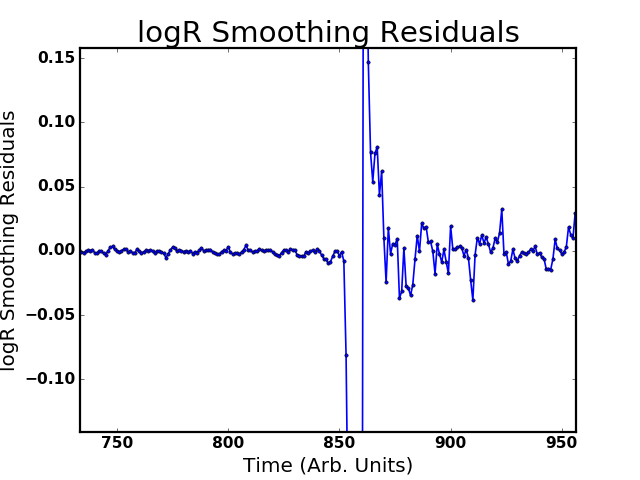

In [243]:
snp.plotz(plt, dfcut.time, dfcut.residuals, tmlab, "logR Smoothing Residuals", "logR Smoothing Residuals")

## Smoothing the Residuals of Smoothing...Meta'd

<IPython.core.display.Javascript object>


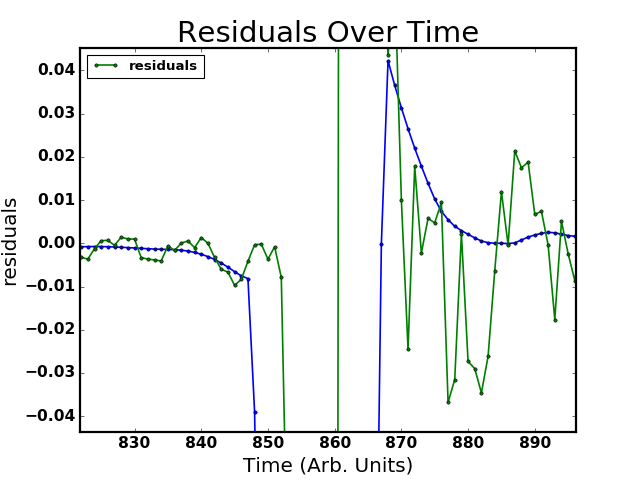

In [245]:
# lowess returns a numpy array, so we need to pull out the smoothed y-values.
smoothed_residuals = lowess(dfcut.residuals, dfcut.time, 0.015, 4, is_sorted=False, delta = 0.001)[:,1] 

smooth_logrj = snp.plotz(plt, dfcut.time, smoothed_residuals, tmlab, "residuals", "Smoothed Residuals Over Time")
normal_logrj = snp.plotz(plt, dfcut.time, dfcut.residuals, tmlab, "residuals", "Residuals Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=2, loc = "upper left")
# plt.legend.loc()

<h1 style="background-color:yellow">160601</h1>

## Wrapper Function to Prep Data
Before continuing with stuff I'd like to wrap up the data cleaning / prep code from yesterdays entry into one fully automated function called prepdata() that will spit out the equivalent of `dfcut` with all it's additional columns. It won't do any of the smoothing stuff yet. I exported this notebook to a .py and I'll just cull out the unnecessary stuff. The resulting file will be dataprep.py.

I also just realized that we should use the smoothed Rjs to calculate Pj, so we don't need them in the prepdata.py returned DF.

In [181]:
df = prepdata.prepdata(datafile)

C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\prepdata.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfcut["rj"] = dfcut.r-Rseries
C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\prepdata.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfcut["time"] = dfcut.index.tolist()
C:\Users\Sonya\Anaconda3\lib\site-packages\pandas\core\generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [182]:
df.head()

,v,i,r,rj,time,logrj
870,0.5935,0.002962,200.338821,0.685297,0,-0.164121
871,0.5935,0.002962,200.342957,0.689433,1,-0.161508
872,0.5935,0.002963,200.331863,0.678339,2,-0.168553
873,0.5935,0.002963,200.332336,0.678812,3,-0.168251
874,0.5935,0.002963,200.332611,0.679087,4,-0.168075


OK that seems to be working fine. Now I want to proceed with the smoothing analysis - ultimately this will get it's own wrapper also. From yesterday we decided to do run some naive smoothing and on log(Rj) and use the residuals between the smooth and the data to indicate what regions of the curve we should smooth heavily and which we should avoid (namely the "climb" region). From yesterday we were at the point of needing to decide on a 'cut off' for the smoothed residuals such that any residual whose absolute value is below the cut-off will be ignored by the first pass aggressive smoothing. Maybe I should go ahead and create a wrapper for the smoothing functionality so far. First let me outline the full smoothing steps:
1. Do naive smoothing to whole curve
2. Compute residuals between the smoothed and original data
3. Smooth the computed residuals
4. Filter the residuals by some cut off for magnitude (**WARNING: the residuals cross zero in the middle of the climb!**)
5. For all points below the filter cut off apply aggressive naive smoothing
6. For a small subset of points at the boundaries between the smoothing regions and the "climb" apply some slight smoothing to interpolate

## Wrapper Function for First Part of Smoothing

In [183]:
%aimport smoothdata
smdf = smoothdata.smoothdata(df)

In [184]:
smdf.head()

,v,i,r,rj,time,logrj,residuals,smabsresiduals
870,0.5935,0.002962,200.338821,0.685297,0,-0.164121,0.003298,0.003926
871,0.5935,0.002962,200.342957,0.689433,1,-0.161508,0.004943,0.003738
872,0.5935,0.002963,200.331863,0.678339,2,-0.168553,-0.003075,0.003558
873,0.5935,0.002963,200.332336,0.678812,3,-0.168251,-0.003747,0.003387
874,0.5935,0.002963,200.332611,0.679087,4,-0.168075,-0.004548,0.003229


<IPython.core.display.Javascript object>


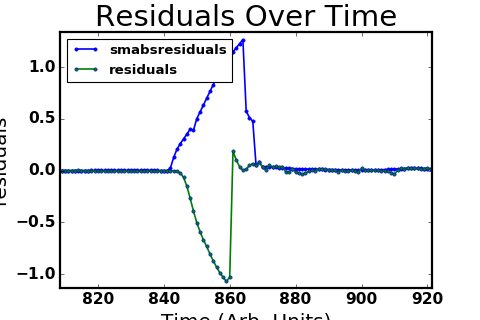

In [187]:
smooth_logrj = snp.plotz(plt, smdf.time, smdf.smabsresiduals, tmlab, "residuals", "Smoothed Residuals Over Time")
normal_logrj = snp.plotz(plt, smdf.time, smdf.residuals, tmlab, "residuals", "Residuals Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=2, loc = "upper left")
# plt.legend.loc()

<h1 style="background-color:yellow">160602</h1>

## Modify Smoothing to Work with Abs(residuals)

I had a thought that really I ought to compute the residuals from smoothing, take their absolute value and then smooth that. Let me try modifying smoothdata.py to reflect this new approach. Note that I also added up at the top of this notebook a few "overhead" commands that I should run every time the notebook is opened. They get me to the point of a prepped data frame called "df" and define some commonly used constants in this notebook.

In [215]:
df = prepdata.prepdata(datafile)
smdf = smoothdata.smoothdata(df)

C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\prepdata.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfcut["rj"] = dfcut.r-Rseries
C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\prepdata.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfcut["time"] = dfcut.index.tolist()
C:\Users\Sonya\Anaconda3\lib\site-packages\pandas\core\generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [216]:
smdf.head()

,v,i,r,rj,time,logrj,residuals,smabsresiduals
870,0.5935,0.002962,200.338821,0.685297,0,-0.164121,0.003298,0.003926
871,0.5935,0.002962,200.342957,0.689433,1,-0.161508,0.004943,0.003738
872,0.5935,0.002963,200.331863,0.678339,2,-0.168553,-0.003075,0.003558
873,0.5935,0.002963,200.332336,0.678812,3,-0.168251,-0.003747,0.003387
874,0.5935,0.002963,200.332611,0.679087,4,-0.168075,-0.004548,0.003229


<IPython.core.display.Javascript object>


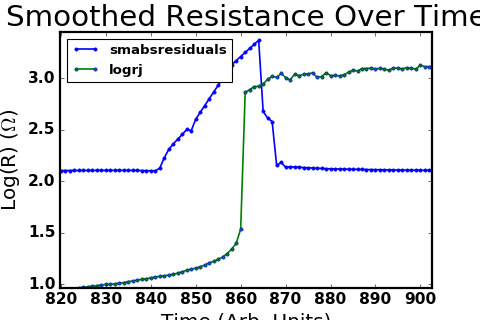

In [110]:
smooth_logrj = snp.plotz(plt, smdf.time, smdf.smabsresiduals + 2.1, tmlab, "residuals", "Smoothed Residuals Over Time")
normal_logrj = snp.plotz(plt, df.time, df.logrj, tmlab, logrlab, "Smoothed Resistance Over Time")
plt.legend(numpoints=2, loc = "upper left")

## Finding a Cut-Off Window for Smoothing Regions

OK I think that will work pretty well. I need to set up a cutoff window that is the region between the first and second occurence of e.g. smoothed_abs_residuals > 0.05 or some value like that. Let me just try that by hand:

<IPython.core.display.Javascript object>


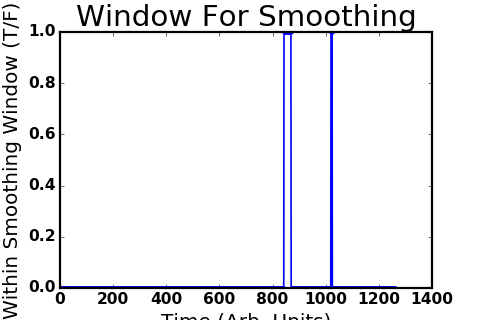

In [190]:
window = smdf.smabsresiduals > 0.05
window_plot = snp.plotz(plt, smdf.time, window, tmlab, "Within Smoothing Window (T/F)", "Window For Smoothing")

OK that works pretty well, I can make a boolean column for the data frame that is "smwindow" and only True for data points that are outside the "climb" window i.e. data points that should be smoothed! I don't really care about the extra windows that show up way out in the noisy plateau region as we will disregard that region eventually anyway.

In [217]:
smdf["smwindow"] = smdf.smabsresiduals < 0.05

## Finding the Start/End Points of Cut-Off Window

Now I want to smooth the logr column but only in regions where smwindow is True. But note that I can't just pull all those points out into one list because then at the point where they join there will be smoothing, but those points are not actually contiguous! So I'll pull out the first section which is the "ramp" and the second region which is the "plateau" and smooth them separately. What is the best way to do this? I want to find the first instance where smwindow goes from False to True and the first instance where it goes from True to False. How can I do this? Well, if I create a column which is the value of smwindow but shifted down by one, then I can do an XOR on smwindow and shiftedsmwindow and just pull out the first two points of this XOR list that are True. From wikipedia:
> The XOR gate (sometimes EOR gate, or EXOR gate and pronounced as Exclusive OR gate) is a digital logic gate that implements an exclusive or; that is, a true output (1/HIGH) results if one, and only one, of the inputs to the gate is true. If both inputs are false (0/LOW) or both are true, a false output results. XOR represents the inequality function, i.e., the output is true if the inputs are not alike otherwise the output is false. A way to remember XOR is "one or the other but not both".

The pandas shift(n) shifts a column by n rows (can be negative) and then removes elements and adds NaNs as necessary to shape the column back into alignment with the data frame. For this data there is absolutely no loss in discarding the last data point so I will create a new column which is smwindow shifted up by one, and then I will remove the last row of the dataframe.

In [218]:
smdf["shiftwindow"] = smdf.smwindow.shift(-1)
smdf = smdf[:-1]

Now I need to make a column which is the result of Xoring shiftwindow and smwindow. Xor is easy to implement, but it is already built in to the operator module and calling it by name will make it easier to recognize. But for now opt for simplicity

In [219]:
smdf["xorwindow"] = smdf.shiftwindow != smdf.smwindow  # This is an XOR operation!

C:\Users\Sonya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [220]:
smdf.xorwindow.describe()

count      1262
unique        2
top       False
freq       1258
Name: xorwindow, dtype: object

In [221]:
smdf.head()

,v,i,r,rj,time,logrj,residuals,smabsresiduals,smwindow,shiftwindow,xorwindow
870,0.5935,0.002962,200.338821,0.685297,0,-0.164121,0.003298,0.003926,True,True,False
871,0.5935,0.002962,200.342957,0.689433,1,-0.161508,0.004943,0.003738,True,True,False
872,0.5935,0.002963,200.331863,0.678339,2,-0.168553,-0.003075,0.003558,True,True,False
873,0.5935,0.002963,200.332336,0.678812,3,-0.168251,-0.003747,0.003387,True,True,False
874,0.5935,0.002963,200.332611,0.679087,4,-0.168075,-0.004548,0.003229,True,True,False


It looks like there are four instances where it switches values. I imagine two  of them are from out in the noisy plateau region. Let me get the indices for where xorwindow is True, then I will use the first two of them to be the end point of the ramp and start point of the plateau respectively. 

In [62]:
# make a new data frame that selects only rows where xorwindow is True, then turn it's index into a list
points = smdf[smdf.xorwindow].index.tolist()   
points = points[0:2]  # take the first two points which are the end of the ramp and start of the plateau
points

[1712, 1739]

## Smoothing the Ramp and Plateau Regions Separately

Now I'll make two new series which are the logr values in the ramp, and the logr values in the plateau, and we'll smooth them.

In [223]:
# selecting a slice of a column by index values - this makes a series!
ramp = smdf.logrj.ix[0:points[0]]  

lowess = sm.nonparametric.lowess
sm_ramp =lowess(ramp, ramp.index.tolist(), 0.02, 30, is_sorted=False, delta = 0.001)[:,1]
sm_ramp =lowess(sm_ramp, ramp.index.tolist(), 0.04, 10, is_sorted=False, delta = 0.001)[:,1]
sm_ramp =lowess(sm_ramp, ramp.index.tolist(), 0.08, 2, is_sorted=False, delta = 0.001)[:,1]
#sm_ramp =lowess(ramp.index.tolist(),sm_ramp, 0.1, 3, is_sorted=False, delta = 0.001)[:,1]

In [224]:
snp.plotz(plt, ramp.index.tolist(), sm_ramp, tmlab, logrlab, "Smoothed Resistance Over Time")

In [225]:
# selecting a slice of a column by index values - this makes a series!
plateau = smdf.logrj.ix[points[1]:]

lowess = sm.nonparametric.lowess
sm_plateau =lowess(plateau, plateau.index.tolist(), 0.02, 30, is_sorted=False, delta = 0.001)[:,1]
sm_plateau =lowess(sm_plateau, plateau.index.tolist(), 0.04, 10, is_sorted=False, delta = 0.001)[:,1]
sm_plateau =lowess(sm_plateau, plateau.index.tolist(), 0.08, 2, is_sorted=False, delta = 0.001)[:,1]

In [226]:
snp.plotz(plt, plateau.index.tolist(), sm_plateau, tmlab, logrlab, "Smoothed Resistance Over Time")

Notice that in the plateau region we really only care about the first maybe 5% of the data. 

Now I would like to plot these two regions together with the actual data, eek!

In [227]:
snp.plotz(plt, plateau.index.tolist(), sm_plateau, tmlab, logrlab, "Smoothed Sections")
snp.plotz(plt, ramp.index.tolist(), sm_ramp, tmlab, logrlab, "Smoothed Sections")
snp.plotz(plt, smdf.index.tolist(), smdf.logrj, tmlab, rlab, "Smoothed Sections")

## Merging Smoothed Ramp and Plateau Back with Unsmoothed Climb

Now we need to merge the smoothed ramp and plateau regions back with the unsmoothed climb data to make a new smlogrj column in our smdf data frame. I can do this by setting the plateau and ramp *Series* values equal to the new smoothed values (which are in numpy array format).

In [235]:
plateau[:] = sm_plateau
ramp[:] = sm_ramp

In [236]:
plateau.head()

1739    2.997156
1740    3.000797
1741    3.004478
1742    3.008197
1743    3.011955
Name: logrj, dtype: float64

Now I need a series which is the logr values between the two points which defined the end of ramp and start of plateau, so I need:

In [237]:
climb = smdf.logrj.ix[points[0]+1:points[1]-1]  
smdf["smlogrj"] = pd.concat([ramp, climb, plateau])  # conatenate stacks on top of one another

## Something Keeps Resetting smlogrj (update: solved)

In [239]:
smdf.head()

,v,i,r,rj,time,logrj,residuals,smabsresiduals,smwindow,shiftwindow,xorwindow,smlogrj
870,0.5935,0.002962,200.338821,0.685297,0,-0.165868,0.003298,0.003926,True,True,False,-0.165868
871,0.5935,0.002962,200.342957,0.689433,1,-0.164864,0.004943,0.003738,True,True,False,-0.164864
872,0.5935,0.002963,200.331863,0.678339,2,-0.163860,-0.003075,0.003558,True,True,False,-0.163860
873,0.5935,0.002963,200.332336,0.678812,3,-0.162855,-0.003747,0.003387,True,True,False,-0.162855
874,0.5935,0.002963,200.332611,0.679087,4,-0.161849,-0.004548,0.003229,True,True,False,-0.161849


Now apply one round of gentle smoothing to glue the smoothed ramp and plateau to the unsmoothed climb in a reasonable way!

<IPython.core.display.Javascript object>


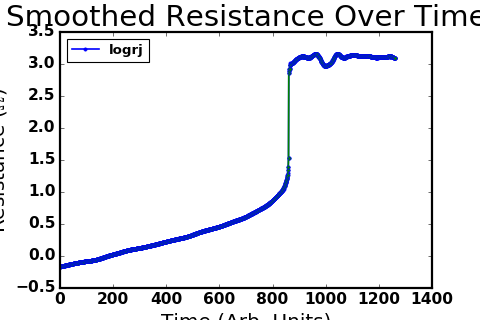

In [233]:
smdf["glued"] = lowess(smdf.smlogrj, smdf.time, 0.02, 5, is_sorted=False, delta = 0.1)[:,1] 

smooth_logrj = snp.plotz(plt, smdf.time, smdf.logrj, tmlab, rlab, "Smoothed Resistance Over Time")
normal_logrj = snp.plotz(plt, smdf.time, smdf.glued, tmlab, rlab, "Smoothed Resistance Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=1, loc = "upper left")
# plt.legend.loc()

Let me wrap some of this smoothing procedure up into smoothdata.smoothdata(). OK, now everything up to the "gluing" smooth operation is included in here.

**Hmmmm, need to figure out why the logrj column of smdf keeps getting set to the same values of smlogrj. UPDATE: I figured it out.** I was calling ` ramp = df.logrj.ix[0:points[0]]` and then later `ramp[:] = sm_ramp`. But the first line is NOT creating a new series object ramp that has the same values, instead it is just providing another tag or handle to that slice of the dataframe, which I was then assigning new values to!  This still doesn't really make sense to me, I mean when you slice a list you get back a different object and don't have this weird lingering association. The documentation on ix doesn't mention anything about it. 

In [31]:
df.head()

,v,i,r,rj,time,logrj,residuals,smabsresiduals,smwindow,shiftwindow
870,0.5935,0.002962,200.338821,0.685297,0,-0.164121,0.003298,0.003926,True,True
871,0.5935,0.002962,200.342957,0.689433,1,-0.161508,0.004943,0.003738,True,True
872,0.5935,0.002963,200.331863,0.678339,2,-0.168553,-0.003075,0.003558,True,True
873,0.5935,0.002963,200.332336,0.678812,3,-0.168251,-0.003747,0.003387,True,True
874,0.5935,0.002963,200.332611,0.679087,4,-0.168075,-0.004548,0.003229,True,True


In [89]:
df = prepdata.prepdata(datafile)
smdf = smoothdata.smoothdata(df)
smdf.head()

C:\Users\Sonya\Box Sync\Projects\python-em-breaking-rate\prepdata.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfcut["rj"] = dfcut.r-Rseries
C:\Users\Sonya\Box Sync\Projects\python-em-breaking-rate\prepdata.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfcut["time"] = dfcut.index.tolist()
C:\Users\Sonya\Anaconda3\lib\site-packages\pandas\core\generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

,v,i,r,rj,time,logrj,residuals,smabsresiduals,smwindow,shiftwindow,xorwindow,smlogrj
870,0.5935,0.002962,200.338821,0.685297,0,-0.164121,0.003298,0.003926,True,True,False,-0.165868
871,0.5935,0.002962,200.342957,0.689433,1,-0.161508,0.004943,0.003738,True,True,False,-0.164864
872,0.5935,0.002963,200.331863,0.678339,2,-0.168553,-0.003075,0.003558,True,True,False,-0.163860
873,0.5935,0.002963,200.332336,0.678812,3,-0.168251,-0.003747,0.003387,True,True,False,-0.162855
874,0.5935,0.002963,200.332611,0.679087,4,-0.168075,-0.004548,0.003229,True,True,False,-0.161849


OK solved the weird issue of logrj column of smdf getting overwritten with the smlogrj values (see above).

C:\Users\Sonya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


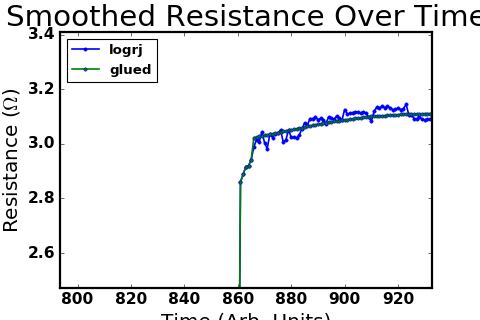

In [91]:
smdf["glued"] = lowess(smdf.smlogrj, smdf.time, 0.02, 7, is_sorted=False, delta = 0.1)[:,1] 

smooth_logrj = snp.plotz(plt, smdf.time, smdf.logrj, tmlab, rlab, "Smoothed Resistance Over Time")
normal_logrj = snp.plotz(plt, smdf.time, smdf.glued, tmlab, rlab, "Smoothed Resistance Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=1, loc = "upper left")
# plt.legend.loc()

OK this first pass is naive window approach isn' going to work quite as well as I hoped. I think instead there will need to more rounds of smoothing of the glue regions :(  Or Maybe the smoothing window could widen on each smoothing iteration...? I could try implementing something like that on the ramp region side. Mmmm, dunno this needs a lot more work....

<h1 style="background-color:yellow">160603</h1>

## Implementing a "Moving" Smoothing Window
OK I am trying to implement a "moving" window to avoid this issue that endpoints of a smooth always get super distorted. 

In [70]:
df = prepdata.prepdata(datafile)
smdf = smoothdata.smoothdata(df)

C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\prepdata.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfcut["rj"] = dfcut.r-Rseries
C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\prepdata.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfcut["time"] = dfcut.index.tolist()
C:\Users\Sonya\Anaconda3\lib\site-packages\pandas\core\generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [23]:
smdf.head()

,v,i,r,rj,time,logrj,residuals,smabsresiduals,smwindow,shiftwindow,xorwindow,smlogrj
870,0.5935,0.002962,200.338821,0.685297,0,-0.164121,0.003298,0.003926,True,True,False,-0.167072
871,0.5935,0.002962,200.342957,0.689433,1,-0.161508,0.004943,0.003738,True,True,False,-0.166052
872,0.5935,0.002963,200.331863,0.678339,2,-0.168553,-0.003075,0.003558,True,True,False,-0.165031
873,0.5935,0.002963,200.332336,0.678812,3,-0.168251,-0.003747,0.003387,True,True,False,-0.164011
874,0.5935,0.002963,200.332611,0.679087,4,-0.168075,-0.004548,0.003229,True,True,False,-0.162991


<IPython.core.display.Javascript object>


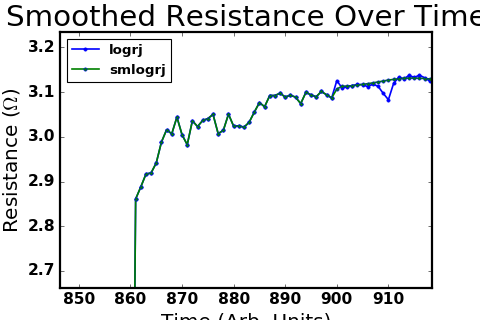

In [71]:
smooth_logrj = snp.plotz(plt, smdf.time, smdf.logrj, tmlab, rlab, "Smoothed Resistance Over Time")
normal_logrj = snp.plotz(plt, smdf.time, smdf.smlogrj, tmlab, rlab, "Smoothed Resistance Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=1, loc = "upper left")
# plt.legend.loc()

## Gluing Smoothed Ramp / Plateau to Unsmoothed Climb

In [81]:
smdf["glued"] = lowess(smdf.smlogrj, smdf.time, 0.01, 2, is_sorted=False, delta = 0.02)[:,1] 

C:\Users\Sonya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


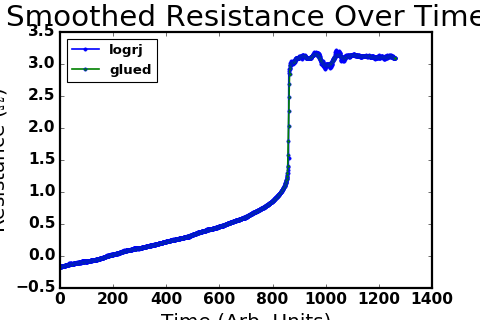

In [83]:
smooth_logrj = snp.plotz(plt, smdf.time, smdf.logrj, tmlab, rlab, "Smoothed Resistance Over Time")
normal_logrj = snp.plotz(plt, smdf.time, smdf.glued, tmlab, rlab, "Smoothed Resistance Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=1, loc = "upper left")
# plt.legend.loc()

OK I have implemented the moving smoothing window in smoothdata.py.  For the ramp region it does 30 smooths where on successive smooths the endpoint of the smooth approaches closer to the actual endpoint of the ramp by 8 points, and the smoothing span decreases by a small step also. The last smooth in this cycle is over the entire ramp region with a smoothing span of 0.02. For the plateau region it is almost identical except it is the startopoint moving leftward with successive smooths.

## Testing On A Second Data Set
After this loop with the moving smooth I do one final "glue" smooth that gently smooths the climb region back into the ramp and plateau regions.  I think this should be ok, but let me try the full protocol on another test file.

In [84]:
datafile = datadir+"\EMC3_1501.txt"
df = prepdata.prepdata(datafile)
smdf = smoothdata.smoothdata(df)

C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\prepdata.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfcut["rj"] = dfcut.r-Rseries
C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\prepdata.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  dfcut["time"] = dfcut.index.tolist()
C:\Users\Sonya\Anaconda3\lib\site-packages\pandas\core\generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

<IPython.core.display.Javascript object>


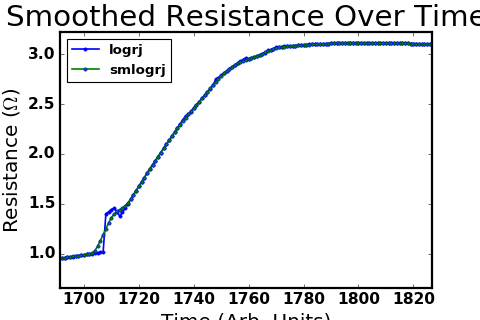

In [33]:
smooth_logrj = snp.plotz(plt, smdf.time, smdf.logrj, tmlab, rlab, "Smoothed Resistance Over Time")
normal_logrj = snp.plotz(plt, smdf.time, smdf.smlogrj, tmlab, rlab, "Smoothed Resistance Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=1, loc = "upper left")
# plt.legend.loc()

In [95]:
smdf["glued"] = lowess(smdf.smlogrj, smdf.time, 0.01, 2, is_sorted=False, delta = 0.02)[:,1] 

C:\Users\Sonya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


<IPython.core.display.Javascript object>


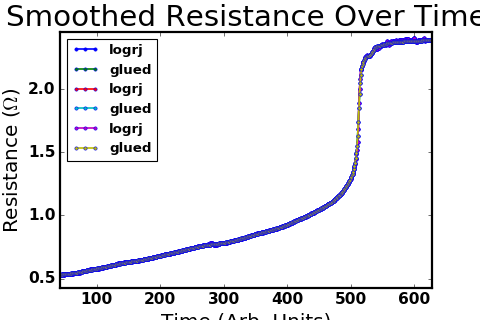

In [96]:
smooth_logrj = snp.plotz(plt, smdf.time, smdf.logrj, tmlab, rlab, "Smoothed Resistance Over Time")
normal_logrj = snp.plotz(plt, smdf.time, smdf.glued, tmlab, rlab, "Smoothed Resistance Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=1, loc = "upper left")
# plt.legend.loc()

## Splining and then Taking First Derivative

Not too bad. May need to have the final script only be semi-automated and prompt the user for different "gluing" values. OK So Now I need to take a numerical derivative of this guy with respect to time...eek.  After some googling there really don't seem to be a lot of options for this kind of thing in python...?  Here are some results:

- Use `numpy.diff` (uses finite differencing where you can specific the order of the derivative)[here](http://stackoverflow.com/questions/20044096/derivative-of-an-array-in-python)
- Use `scipy.fftpack.diff` which doesn't do finite difference, but rather some other technique
- [Spline and then derivative of the spline analytically](http://stackoverflow.com/questions/15862066/gradient-in-noisy-data-python)
- [This](http://math.lanl.gov/Research/Highlights/PDF/tvdiff.pdf) paper and it's python implementation

In [99]:
from scipy.interpolate import splrep, splev

In [142]:
x = smdf.glued.index.tolist()
splfit = splrep(x, smdf.glued.tolist(), k=5, s=0.05)  # k is order of polynomial, s is smoothness

<IPython.core.display.Javascript object>


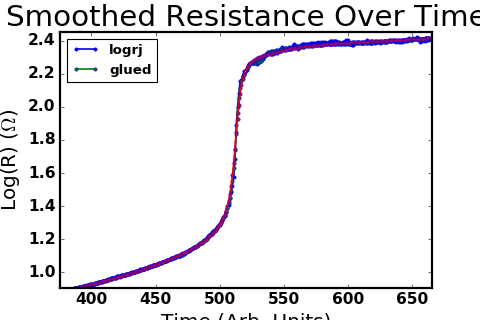

In [154]:
smooth_logrj = snp.plotz(plt, smdf.time, smdf.logrj, tmlab, logrlab, "Smoothed Resistance Over Time")
normal_logrj = snp.plotz(plt, smdf.time, smdf.glued, tmlab, logrlab, "Smoothed Resistance Over Time")
spline_logrj = snp.plotz(plt, smdf.time, splev(x, tck=splfit), tmlab, logrlab, "Smoothed Resistance Over Time")
plt.legend([smooth_logrj, normal_logrj, spline_logrj], ["data", "smoothed", "splined"])

plt.legend(loc = "upper left")

## Computing $\frac{dR_j}{dt}$ from Spline
OK, satisfactory for now... Need to take first derivative now!

<IPython.core.display.Javascript object>


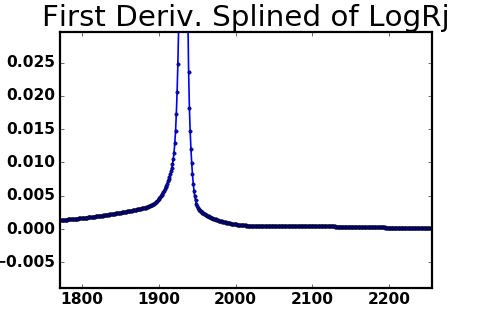

In [191]:
splderiv = splev(x, tck=splfit, der=1)
plt.plot(x, splderiv, label="1st derivative")
plt.title("First Deriv. Splined of LogRj")

## Making Splining Module splderiv.py
This seems good as a first pass - it will need to be smoothed ultimately. Lets create a new module that deals with the numerical differentiation. I'm going to use scipy.interpolate.UnivariateSpline which I think is a newer (cleaner) alternative to splrep. 

In [183]:
%aimport splderiv
smdf = smoothdata.smoothdata(df)
smdf = splderiv.splderiv(smdf)

C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\smoothdata.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["smwindow"] = df.smabsresiduals < 0.05
C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\smoothdata.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # make a new data frame that selects only rows where xorwindow is True, then turn it's index into a list
C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\smoothdata.py:43: SettingWithCopyWarning: 
A value is tryi

In [186]:
smdf = splderiv.splderiv(smdf)

C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\splderiv.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["spl_logrj"] = splfit(df.smlogr.index.tolist())
C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\splderiv.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["spl_drdt"] = splderiv(df.smlogr.index.tolist())


<IPython.core.display.Javascript object>


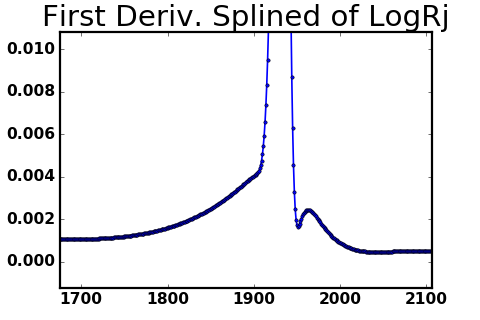

In [190]:
plt.plot(smdf.spl_drdt.index.tolist(), smdf.spl_drdt.tolist(), label="1st derivative")
plt.title("First Deriv. Splined of LogRj")

For some reason this new result with UnivariateSpline is not as nice...?  I don't know if that is a reflection of the univariate spline or some changes I made to all the other smoothing? Let me check...

In [192]:
x = smdf.glued_rj.index.tolist()
splfit = splrep(x, smdf.glued_rj.tolist(), k=5, s=0.05)  # k is order of polynomial, s is smoothness

<IPython.core.display.Javascript object>


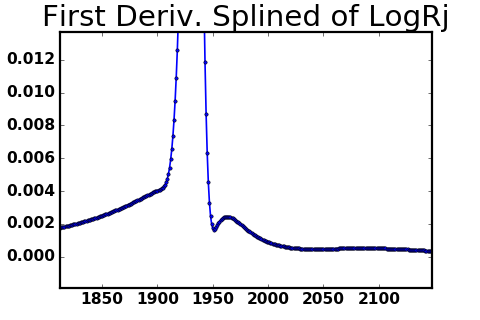

In [194]:
splderiv = splev(x, tck=splfit, der=1)
plt.plot(x, splderiv, label="1st derivative")
plt.title("First Deriv. Splined of LogRj")

OK, so it was something with the smoothing, so I will proceed with Univariate spline. It looks though Like I am going to need to do some smoothing on the spline derivative ultimately.

## Smoothing Current (I) Before Computing Power

Ultimately we want a plot of dRj/dt versus Pj but the calculation of Pj requires the current. Probably we should do some smoothing of the current before doing the calculation. Also should we use the spline evaluated values of R for this calculation or just the numerically smoothed ones? First lets inspect the current. 

<IPython.core.display.Javascript object>


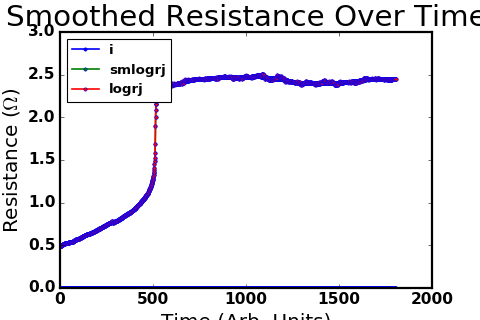

In [161]:
normal_i = snp.plotz(plt, smdf.time, smdf.i, tmlab, ilab, "Current Over Time")

It seems actually like a similar moving window smooth will be necessary. Let me first try to refactor my smoothdata code to be a bit more modular, then maybe it could be applied easily to current as well.

C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\smoothdata.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["xorwindow"] = df.shiftwindow != df.smwindow  # This is an XOR operation!
C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\smoothdata.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["smlogrj"] = df.logrj
C:\Users\Sonya\Anaconda3\lib\site-packages\pandas\core\indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the ca

<IPython.core.display.Javascript object>


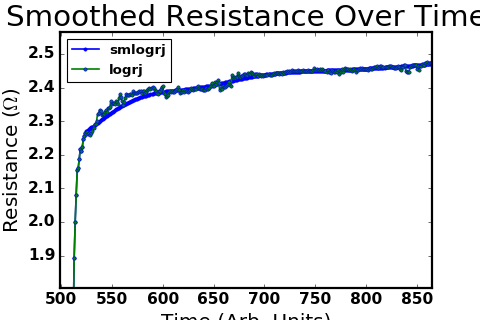

In [174]:
smdf = smoothdata.smoothdata(df)
smooth_logrj = snp.plotz(plt, smdf.time, smdf.smlogrj, tmlab, rlab, "Smoothed Resistance Over Time")
normal_logrj = snp.plotz(plt, smdf.time, smdf.logrj, tmlab, rlab, "Smoothed Resistance Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=1, loc = "upper left")
# plt.legend.loc()

OK so the modularized code works really well!  I will now add in the windowsmoothing application to current. Note that since voltage is constant current will exhibit ramp / climb / plateau transitions at exactly the same index as resistance, this means we can use the two points we identified earlier from the residuals to bookend our "climb" window for current. 

C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\smoothdata.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["xorwindow"] = df.shiftwindow != df.smwindow  # This is an XOR operation!
C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\smoothdata.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df["smlogrj"] = df.logrj
C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\smoothdata.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Data

<IPython.core.display.Javascript object>


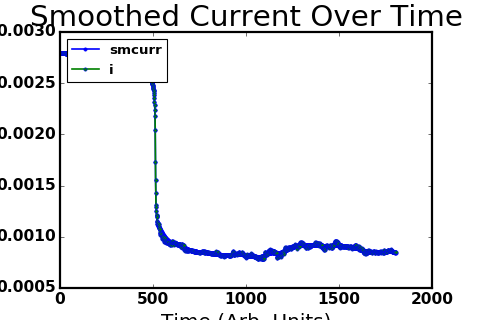

In [175]:
smdf = smoothdata.smoothdata(df)
smooth_logrj = snp.plotz(plt, smdf.time, smdf.smcurr, tmlab, ilab, "Smoothed Current Over Time")
normal_logrj = snp.plotz(plt, smdf.time, smdf.i, tmlab, ilab, "Smoothed Current Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=1, loc = "upper left")
# plt.legend.loc()

## Computing Pj from Smoothed Log(Rj) and Smoothed I
OK that is probably good enough. Now I will calculate $P_j$ from the smoothed current and exponentiating the smoothed logrj.

In [197]:
smdf["pj"] = 10**smdf.smlogrj*smdf.smcurr**2

C:\Users\Sonya\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [198]:
smdf.pj.head()

1420    0.000024
1421    0.000024
1422    0.000024
1423    0.000024
1424    0.000025
Name: pj, dtype: float64

Let's see how the power looks over time.

<IPython.core.display.Javascript object>


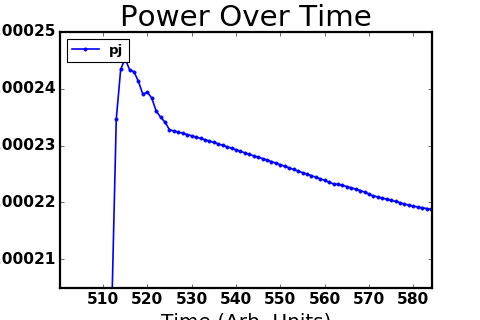

In [208]:
power = snp.plotz(plt, smdf.time, smdf.pj, tmlab, "Junction Power (W)", "Power Over Time")
plt.legend(numpoints=1, loc = "upper left")

This could use smoothing too!  Good lord, everything needs to smoothed over and over again!

In [215]:
lowess = sm.nonparametric.lowess  # rename module method for easier access
smpj = lowess(smdf.pj, smdf.time, 0.015, 2, is_sorted=False, delta=0.1)[:, 1]

<IPython.core.display.Javascript object>


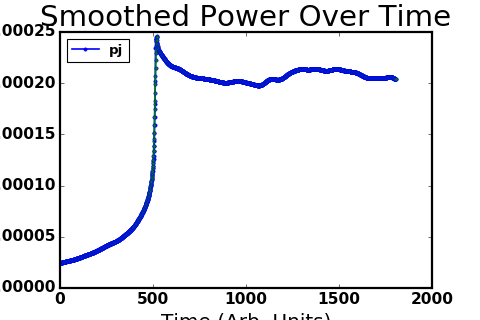

In [217]:
power = snp.plotz(plt, smdf.time, smdf.pj, tmlab, "Junction Power (W)", "Smoothed Power Over Time")
sm_power = snp.plotz(plt, smdf.time, smpj, tmlab, "Junction Power (W)", "Smoothed Power Over Time")
plt.legend(numpoints=1, loc = "upper left")

<IPython.core.display.Javascript object>


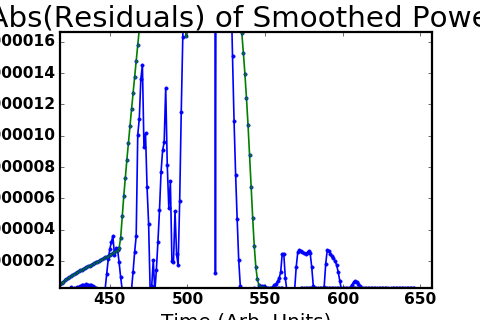

In [223]:
residuals = smdf.pj.tolist() - smpj
absresiduals = abs(residuals)
smoothed_abs_residuals = lowess(absresiduals, smdf.time, 0.05, 6, is_sorted=False, delta=0.001)[:, 1]

snp.plotz(plt, smdf.time, absresiduals, tmlab, "abs(residuals) of power", "Abs(Residuals) of Smoothed Power Over Time")
snp.plotz(plt, smdf.time, smoothed_abs_residuals, tmlab, "abs(residuals) of power","Smoothed Abs(Residuals) of Smoothed Power Over Time")

The above residuals look like they would bive the exact same sort of window as the residuals did for logrj previously. This could allow me to abstract the find-window code and modularize so as to apply it here, and to the drdt curve potentially. First let me take stock of what the data flow looks like so far:

1. Read in data, rename, compute logrj (prepdata.py)
2. naive smooth of logrj, then calculate residuals, then smooth them, then use smoothed residuals to define a "window"
3. Apply moving smoothing to the region before and after this window
4. Apply smoothing globally to logrj to "glue together" 
5. spline logrj and take derivative
6. Apply (5) and (6) to current
7. Calculate Pj from smoothed logrj and smoothed current
8. Smooth Pj
9. Smooth drdt

Both (8) and (9) will require some non-naive smoothing just like logrj and current. This is because they have their own non-trivial shape (both have a very sharp peak). I think I should try to modularize the "find" window code. It should take in a series and output the window.

## Modularizing the Code Some More with Smoothing sub-functions

Just created the findwindow() function, need to make sure smoothdata() still works as expected.

In [279]:
df = prepdata.prepdata(datafile)
smdf = smoothdata.smoothdata(df)

C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\prepdata.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Sonya\Documents\My Box Files\Projects\python-em-breaking-rate\prepdata.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\Sonya\Anaconda3\lib\site-packages\pandas\core\generic.py:2698: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydat

In [281]:
smdf.tail()

,v,i,r,rj,time,logrj,smlogrj,smcurr
3221,0.342,0.000851,402.085907,282.879794,1801,2.451602,2.449973,0.000853
3222,0.342,0.000854,400.244507,281.038394,1802,2.448766,2.450106,0.000853
3223,0.342,0.000853,400.868713,281.662600,1803,2.449729,2.450239,0.000852
3224,0.342,0.000853,400.911896,281.705783,1804,2.449796,2.450373,0.000852
3225,0.342,0.000858,398.750092,279.543979,1805,2.446450,2.450506,0.000852


<IPython.core.display.Javascript object>


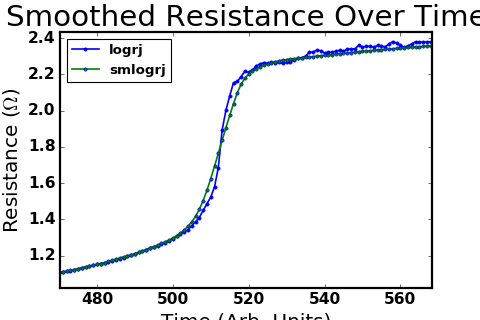

In [282]:
smooth_logrj = snp.plotz(plt, smdf.time, smdf.logrj, tmlab, rlab, "Smoothed Resistance Over Time")
normal_logrj = snp.plotz(plt, smdf.time, smdf.smlogrj, tmlab, rlab, "Smoothed Resistance Over Time")
# plt.legend([smooth_r, normal_r], ["test", "test2"])
plt.legend(numpoints=1, loc = "upper left")
# plt.legend.loc()

Yep, still seems to work just fine!

<h1 style="background-color:yellow">160605</h1>

OK I went back through the modularized .py code and made some changes based on my better grasp of pandas (especially indexing with .loc, .iloc, .ix). I need to make sure things are still working...

In [32]:
df = prepdata.prepdata(datafile)
smdf = smoothdata.smoothdata(df)

C:\Users\Sonya\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


In [30]:
smdf.head()

,v,i,r,rj,time,logrj,smlogrj,smcurr
870,0.5935,0.002963,200.338821,0.684510,870,-0.169251,-0.169251,0.002963
871,0.5935,0.002963,200.342957,0.688646,871,-0.168149,-0.168149,0.002963
872,0.5935,0.002963,200.331863,0.677552,872,-0.167047,-0.167047,0.002963
873,0.5935,0.002963,200.332336,0.678025,873,-0.165945,-0.165945,0.002963
874,0.5935,0.002962,200.332611,0.678300,874,-0.164843,-0.164843,0.002962


Hmmmm, something is wrong with the smoothing of the absolute value of residuals in the findwindow function... the line "    sm_abs_residuals = lowess(abs_residuals, indx, 0.02, 8, is_sorted=False, delta=0.001)[:, 1]" doesn't give any difference in sm_abs_residuals no matter what values i put for smoothing... so bizarre. Actually I think it may have been something with debugging...?

<h1 style="background-color:yellow">160606</h1>

Need to resume debugging the modularized code from within pycharm. 

In [5]:
df = prepdata.prepdata(datafile)

In [12]:
smdf = smoothdata.smoothdata(df)

Smoothing will exclude the range from index =  1714  to index =  1733
Smoothing will exclude the range from index =  1918  to index =  1927


<IPython.core.display.Javascript object>


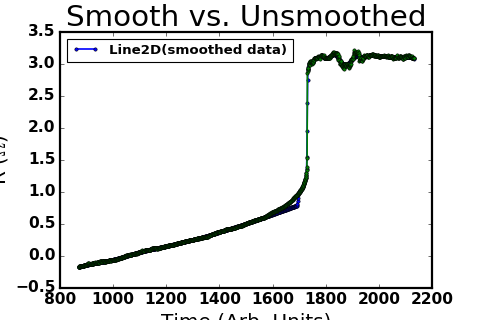

In [13]:
snp.plotsmoothed(plt, smdf.smlogrj, df.logrj, smdf.index.tolist())

<IPython.core.display.Javascript object>


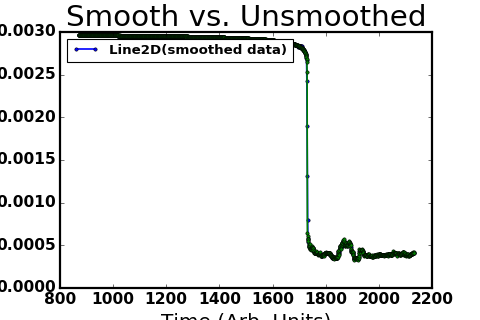

In [14]:
snp.plotsmoothed(plt, smdf.smcurr, df.i, smdf.index.tolist())

In [15]:
smdf.head()

,v,i,r,rj,logrj,smlogrj,smcurr
870,0.5935,0.002962,200.338821,0.684510,-0.164620,-0.168548,0.002963
871,0.5935,0.002962,200.342957,0.688646,-0.162004,-0.167524,0.002963
872,0.5935,0.002963,200.331863,0.677552,-0.169057,-0.166500,0.002962
873,0.5935,0.002963,200.332336,0.678025,-0.168754,-0.165476,0.002962
874,0.5935,0.002963,200.332611,0.678300,-0.168578,-0.164452,0.002962


I am having a lot of mutability issues. I don't understand where they are coming from. Also I am misindentifying the non-smoothing window with my script. OK when it was creating a new DF from the "window" list object the row index was being set automatically starting from 0. 

Maybe I should make a widget that lets you use sliders to manipulate e.g. window step size in ramp region, step size for the smoothing span parameter as it goes through those windows, and maybe some other element of aggressiveness in the plotting? Then I could have an identical thing for the "gluing together" smoothing. Hmmm, is this worth it, or do I want to hold out hope for a fully automated approach? 

In [17]:
%aimport splderiv
test1, test2 = splderiv.splderiv(smdf.logrj)

<IPython.core.display.Javascript object>


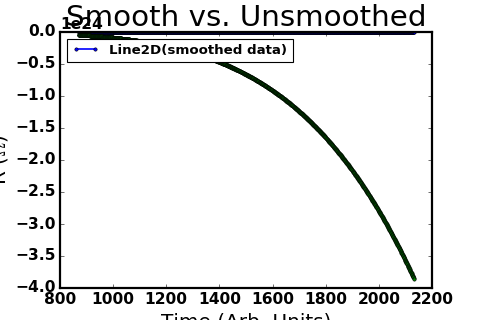

In [18]:
snp.plotsmoothed(plt, smdf.logrj, test1, smdf.index.tolist())

For some reason the procedure for finding the smoothing window is not working for the current. Is it somehow because this is not log of current as it was for resistance? It's so bizarre - it looks like the smoothing just stops at the climb region. 

<h1 style="background-color:yellow">160617</h1>

OK let me recap where I'm at.
- prepdata.py spits out a df with logrj
- smoothdata.py spits out smoothed current and smoothed logrj
- splderiv.py spits out splined logrj

I wrote main.py which does all of the above and outputs a plot of the unsmoothed logrj, the smoothed logrj and the splined smoothed logrj. The problem I seem to be having now is that for some reason logrj is getting overwritten with smoothlogrj values (this is clear when you look at the plot). 

Also weirdly when I put plt.show() into the main script it prevents the debugging process from running to completion so it makes it look like the script is running forever. Very strange...

Need to figure out legends in Matplotlib. Like, yesterday.

<h1 style="background-color:yellow">160620</h1>

Alrighty. It looks like the overwriting issue is actually that smlogrj and spline are the exact same curve. Is this because the spline function isn't doing anything, or is it because one or the other column is getting overwritten?

In [5]:
cwd = os.getcwd()
datadir = cwd + "\OriginalData"
datafile = datadir+"\EMC1_1112.txt"

df = prepdata.prepdata(datafile)
df.drop(list(range(1850, 2133, 1)), inplace=True)  # EMC1_1112

smdf = smoothdata.smoothdata(df)

Smoothing will exclude the range from index =  1717  to index =  1731


In [6]:
smdf.head()

,v,i,r,rj,logrj,smlogrj
870,0.5935,0.002962,200.338821,0.684510,-0.164620,-0.168579
871,0.5935,0.002962,200.342957,0.688646,-0.162004,-0.167528
872,0.5935,0.002963,200.331863,0.677552,-0.169057,-0.166477
873,0.5935,0.002963,200.332336,0.678025,-0.168754,-0.165426
874,0.5935,0.002963,200.332611,0.678300,-0.168578,-0.164374


In [9]:
%aimport splderiv
spln, splnderiv = splderiv.splderiv(smdf.smlogrj)

In [10]:
smdf.head()

,v,i,r,rj,logrj,smlogrj
870,0.5935,0.002962,200.338821,0.684510,-0.164620,-0.168579
871,0.5935,0.002962,200.342957,0.688646,-0.162004,-0.167528
872,0.5935,0.002963,200.331863,0.677552,-0.169057,-0.166477
873,0.5935,0.002963,200.332336,0.678025,-0.168754,-0.165426
874,0.5935,0.002963,200.332611,0.678300,-0.168578,-0.164374


In [12]:
spln[0:5]

array([-0.16857902, -0.1675278 , -0.16647663, -0.16542551, -0.16437444])

OK that answers that question. The splderiv function is either returning the unsplined thing, or basically not splining. It looks like I had the 'smoothing' parameter set to 0, so it was just returning a splin that exactly fit the data. 

For sm = 0.05 in the spline it actually does a _worse_ job than the straight up smoothed data. I went ahead and modularized main a bit more so that I can call it with different values of smoothing and those get passed into the splderiv function.

Smoothing will exclude the range from index =  1717  to index =  1731


<IPython.core.display.Javascript object>


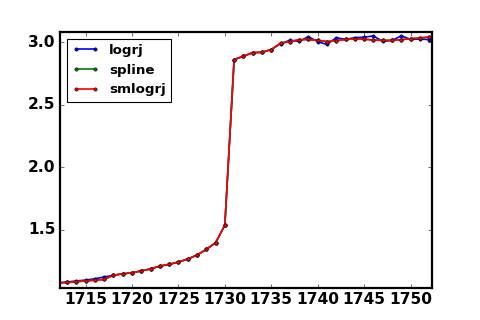

In [16]:
main.main(0.0)

Smoothing will exclude the range from index =  1717  to index =  1731


<IPython.core.display.Javascript object>


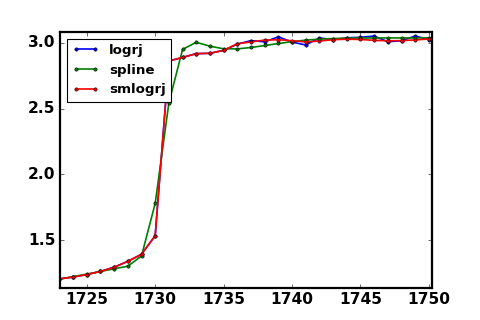

In [17]:
main.main(0.2)

Hmmm, I think maybe I should not use the spline to get any more smoothing effect, instead I should just use it as a means to get a "numerical" differentiation of the smlogrj values. This would correspond to splining with sm=0.0.

Smoothing will exclude the range from index =  1717  to index =  1731


<IPython.core.display.Javascript object>


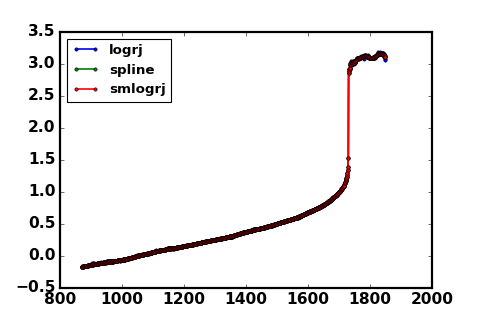

In [22]:
newsmdf = main.main(0.0)

In [19]:
newsmdf.head()

,v,i,r,rj,logrj,smlogrj,spln,splnderiv
870,0.5935,0.002962,200.338821,0.684510,-0.164620,-0.168579,-0.168579,0.001051
871,0.5935,0.002962,200.342957,0.688646,-0.162004,-0.167528,-0.167528,0.001051
872,0.5935,0.002963,200.331863,0.677552,-0.169057,-0.166477,-0.166477,0.001051
873,0.5935,0.002963,200.332336,0.678025,-0.168754,-0.165426,-0.165426,0.001051
874,0.5935,0.002963,200.332611,0.678300,-0.168578,-0.164374,-0.164374,0.001051


<IPython.core.display.Javascript object>


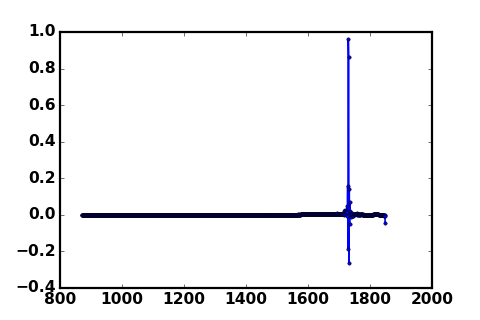

In [23]:
plt.plot(newsmdf.index.tolist(),splnderiv)

<h1 style="background-color:yellow">160707</h1>

OK, pivoting here a bit. Giving up on the super automated data analysis but instead will do semi-automated. Namely, for each trace:
- user chooses the start and end points for analysis
- user chooses the boundary points that define different smoothing regions for Rs/Is, Rates, Power
- user can modulate the aggressiveness of the smoothing in the different regions (slider bars?)
- user can modulate the endpoint for the exponential fit (slide bars?)

Definitely for the first two I can use matplotlibs `ginput` functionality (works just like matlabs, as in the contact angle script I wrote. Going to implement this in main.py right now.